In [1]:
import itertools
import pathlib
import pyam

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# these functions can be found in utils.py in this same directory
from utils import (
    make_quantiles,
    make_sequestration_plot_data,
    sequestration_plot,
    share_of_cdr_data,
)

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

# Load Data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
paper_data = pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
])

In [4]:
ar6_data = pd.read_csv(data_path / 'AR6_Scenarios_Database_World_v1.0.csv')
ar6_data = ar6_data[ar6_data.Variable.isin(['Emissions|CO2|AFOLU'])]

In [5]:
df = pyam.IamDataFrame(pd.concat([paper_data, ar6_data]))
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators for 914 out of 1874 scenarios


In [6]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

In [7]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only from 2020',
 'Cumulative AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Cumulat

# Panel 1A

In [8]:
variables = [
    'Emissions|CO2|AFOLU',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
]

data = pyam.concat([
    make_quantiles(df, v, cat)
    for v, cat in itertools.product(variables, categories_to_temp.keys())
])

In [9]:
def afolu_line_plot(data, variables, cat, ax=None, years=range(1990, 2051), color='variable'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.25*', '*0.75*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color=color, fill_between=True, ax=ax, alpha=0.1, legend=False) #  cmap='PiYG_r',
    )
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.5*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color=color, ax=ax)  # cmap='PiYG_r',
    )
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-len(variables):], l[-len(variables):])
    return ax

In [10]:
color_map = {
    'Emissions|CO2|AFOLU': '#' + 'c' * 6,
    'LULUCF Emissions - BK/IAM Reporting Convensions': '#33701a',
    'LULUCF Emissions - NGHGI Reporting Conventions': '#a3176d', 
}
pyam.run_control().update({'color': {'variable': color_map}})

In [11]:
error = pd.read_excel(data_path / 'LUC_uncertainty_AR6_reanalysis.xlsx', sheet_name='Fig1AB')

<AxesSubplot:>

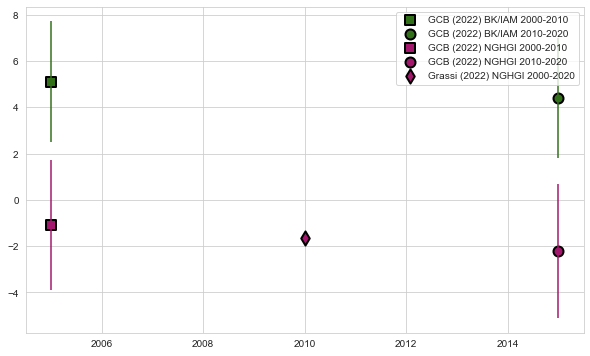

In [12]:
def add_eluc_history(error, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    colors = {
        'BK/IAM': '#33701a',
        'NGHGI': '#a3176d', 
    }
    markers = {
        '2000-2010': 's',
        '2010-2020': 'o', 
        '2000-2020': 'd',
    }
    for i, row in error.iterrows():
        label = ' '.join((row['label'], row['emissions'], row['period']))
        ax.scatter(row['plot_year'], row['mean'], marker=markers[row['period']],  label=label, 
                   color=colors[row['emissions']], s=100, edgecolor='k', linewidths=2)
        ax.errorbar(row['plot_year'], row['mean'], row['std'], color=colors[row['emissions']])
    ax.legend()
    return ax

add_eluc_history(error)

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


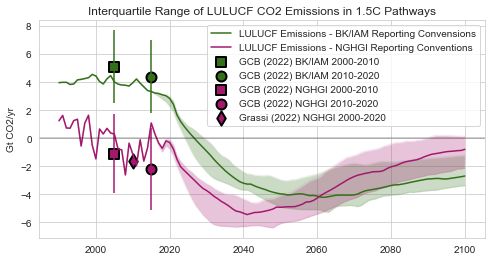

In [13]:
cat = 'C1'

variables = {
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'LULUCF Emissions - BK/IAM Reporting Convensions',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'LULUCF Emissions - NGHGI Reporting Conventions', 
}
fig, ax = plt.subplots(figsize=(8, 4))
afolu_line_plot(data.rename(variable=variables), variables.values(), cat, years=range(1990, 2101), ax=ax)
add_eluc_history(error, ax=ax)
ax.axhline(0, c='k', alpha=0.25)

ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')
h, l = ax.get_legend_handles_labels()
ax.legend(h[-7:], l[-7:])

fig.savefig('./files/fig1a1.pdf')

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


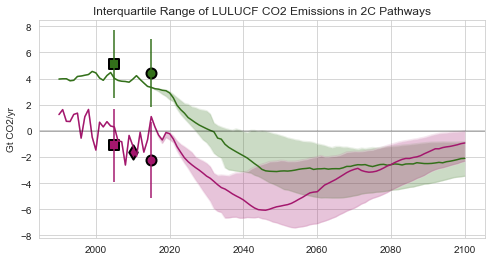

In [14]:
cat = 'C3'

variables = {
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'LULUCF Emissions - BK/IAM Reporting Convensions',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'LULUCF Emissions - NGHGI Reporting Conventions', 
}
fig, ax = plt.subplots(figsize=(8, 4))
afolu_line_plot(data.rename(variable=variables), variables.values(), cat, years=range(1990, 2101), ax=ax)
add_eluc_history(error, ax=ax)
ax.axhline(0, c='k', alpha=0.25)

ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')
ax.legend().remove()

fig.savefig('./files/fig1a2.pdf')

# Panel 1B

In [15]:
error = pd.read_excel(data_path / 'LUC_uncertainty_AR6_reanalysis.xlsx', sheet_name='Fig1C')
error

,label,period,plot_year,mean,std
0,Grassi (2023),2000-2020,2009,6.7,2.5
1,GCB (2022),2000-2020,2011,6.4,1.2
2,OSCAR (this study),2000-2020,2012,4.4,1.0


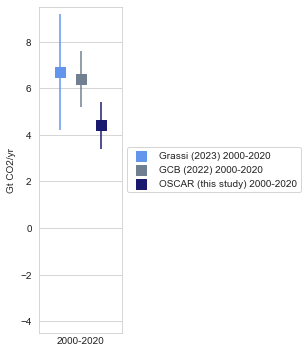

In [41]:
fig, ax = plt.subplots(figsize=(1.5, 6))
markers = {
    '2000-2020': 's',
    '2000-2010': 'd',
    '2005-2015': 'o', 
    '2010-2020': '*',
}
colors = {
    'GCB (2022)': 'slategrey',
    'Grassi (2021)': 'royalblue', 
    'Grassi (2023)': 'cornflowerblue',
    'OSCAR (this study)': 'midnightblue',
}
for i, row in error.iterrows():
    label = ' '.join((row['label'], row['period']))
    ax.scatter(-1 + i, row['mean'], marker=markers[row['period']],  label=label, color=colors[row['label']], s=100)
    ax.errorbar(-1 + i, row['mean'], row['std'], color=colors[row['label']])
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])

# set xticks
ax.set_xlim((-2, 2))
ax.set_xticks([])
ax.set_xlabel('2000-2020')

# conform with below plot
ax.set_ylabel('Gt CO2/yr')
plt.grid(axis='x', visible=False)

# harmonize ylim
ax.set_ylim(-4.5, 9.5)

fig.savefig('./files/fig1b1.pdf', bbox_inches='tight')

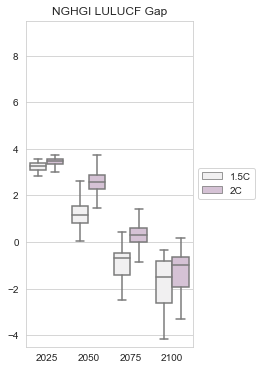

In [42]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
]
name = 'NGHGI LULUCF Gap'
fig, ax = plt.subplots(figsize=(3, 6))
(
    df
    .filter(region='World', variable=variables)
    .filter(Temperature=categories_to_temp.values())
    .filter(year=range(2025, 2101, 25))
    .subtract(variables[0], variables[1], name=name, ignore_units='Mt CO2/yr')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .box(color='thistle', by='Temperature', ax=ax, showfliers=False)
)
ax.set_title(name)
ax.set_xlabel('')
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])

# conform with previous plot
ax.set_ylabel('')

# harmonize ylim
ax.set_ylim(-4.5, 9.5)

fig.savefig('./files/fig1b2.pdf', bbox_inches='tight')

Text(0.5, 0, '')

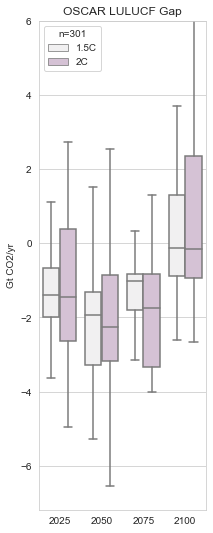

In [18]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
    'Emissions|CO2|AFOLU', 
]
name = 'OSCAR LULUCF Gap'
fig, ax = plt.subplots(figsize=(3, 9))
(
    df
    .filter(region='World', variable=variables)
    .filter(Temperature=categories_to_temp.values())
    .filter(year=range(2025, 2101, 25))
    .subtract(variables[0], variables[1], name=name, ignore_units='Mt CO2/yr')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .box(color='thistle', by='Temperature', ax=ax, showfliers=False)
)
ax.set_title(name)
ax.set_ylim(None, 6)
ax.set_xlabel('')

## Figure for SI

### S2

In [23]:
variables = {
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct': 'Direct Land CDR',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect': 'Indirect Land CDR',
}
hist = [2015, 2020]
hist = [2020]
future = [2030, 2050]
future = [2030, 2050, 2100]
data, pdata = make_sequestration_plot_data(
    df.filter(variable=variables.keys(), region='World').rename({'variable': variables}), 
    variables.values(), 
    categories_to_temp, years=hist + future
)
for year in hist:
    pdata = pdata.drop(f'{year} 1.5C').rename(index={f'{year} 2C': str(year)})

In [24]:
pdata.head()

scenario             0.25                               0.5                    \
variable  Direct Land CDR Indirect Land CDR Direct Land CDR Indirect Land CDR   
index                                                                           
2100 2C          2.198314         -1.940877        3.444095         -0.969279   
2100 1.5C        2.172859         -2.650530        3.639480         -1.489892   
2050 2C          2.677376          2.269403        3.861744          2.554931   
2050 1.5C        3.623632          0.830763        5.437195          1.148278   
2030 2C          2.534827          3.432648        3.169338          3.784413   

scenario             0.75                    
variable  Direct Land CDR Indirect Land CDR  
index                                        
2100 2C          4.666905         -0.622408  
2100 1.5C        4.630951         -0.833032  
2050 2C          5.467439          2.889876  
2050 1.5C        6.291736          1.560559  
2030 2C          4.520329          3.980415

Text(0, 0.5, '')

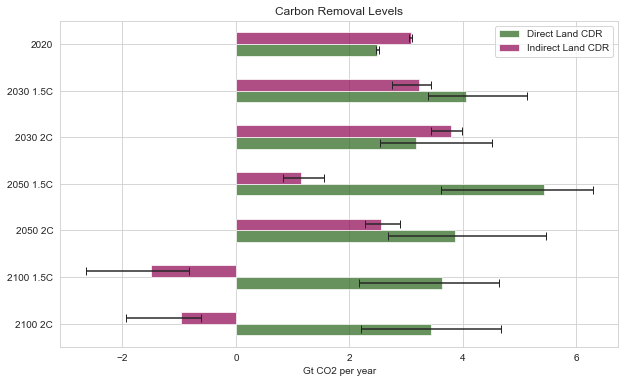

In [25]:
size = 4
fig, ax = plt.subplots(figsize=(2.5 * size, 1.5 * size))
sequestration_plot(
    pdata, 
    medians=False, stacked=False, order=variables.values(), cmap='PiYG_r',
    legend={'loc': 'best'}, ax=ax,
)
ax.set_title('Carbon Removal Levels')
ax.set_xlabel('Gt CO2 per year') 
ax.set_ylabel('')
#ax.set_xlim(0, 18)
#ax.legend(**pyam.plotting.OUTSIDE_LEGEND['bottom'])

In [26]:
pdata/ pdata.loc['2020']

scenario             0.25                               0.5                    \
variable  Direct Land CDR Indirect Land CDR Direct Land CDR Indirect Land CDR   
index                                                                           
2100 2C          0.889908         -0.637839        1.386553         -0.314799   
2100 1.5C        0.879604         -0.871055        1.465213         -0.483882   
2050 2C          1.083839          0.745804        1.554694          0.829782   
2050 1.5C        1.466897          0.273017        2.188953          0.372934   
2030 2C          1.026133          1.128086        1.275939          1.229089   
2030 1.5C        1.367713          0.904038        1.629532          1.049510   
2020             1.000000          1.000000        1.000000          1.000000   

scenario             0.75                    
variable  Direct Land CDR Indirect Land CDR  
index                                        
2100 2C          1.847507         -0.200401  
2100 1.5C        1.833274         -0.268217  
2050 2C          2.164417          0.930474  
2050 1.5C        2.490735          0.502465  
2030 2C          1.789481          1.281603  
2030 1.5C        2.032962          1.107823  
2020             1.000000          1.000000

### S3

In [27]:
variables = ['Cumulative Carbon Sink - Indirect', 'Cumulative Carbon Sink - Direct']
data, pdata = make_sequestration_plot_data(df.filter(region='World'), variables, categories_to_temp, years=future)

Text(0, 0.5, '')

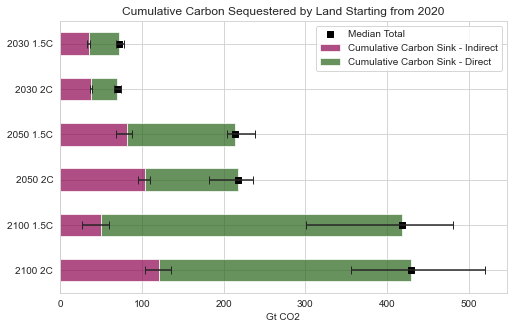

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sequestration_plot(pdata, order=variables, legend={'loc': 'best'}, ax=ax)
ax.set_title('Cumulative Carbon Sequestered by Land Starting from 2020')
ax.set_xlabel('Gt CO2')
ax.set_ylabel('')

In [29]:
pdata / pdata.loc['2050 2C']

scenario                             0.25                                    \
variable  Cumulative Carbon Sink - Direct Cumulative Carbon Sink - Indirect   
index                                                                         
2100 2C                          3.014356                          1.091916   
2100 1.5C                        3.214070                          0.276841   
2050 2C                          1.000000                          1.000000   
2050 1.5C                        1.577283                          0.722640   
2030 2C                          0.358108                          0.379731   
2030 1.5C                        0.425101                          0.349007   

scenario                              0.5                                    \
variable  Cumulative Carbon Sink - Direct Cumulative Carbon Sink - Indirect   
index                                                                         
2100 2C                          2.718107                          1.168708   
2100 1.5C                        3.250865                          0.485658   
2050 2C                          1.000000                          1.000000   
2050 1.5C                        1.173520                          0.781819   
2030 2C                          0.275297                          0.366639   
2030 1.5C                        0.317184                          0.340978   

scenario                             0.75                                    
variable  Cumulative Carbon Sink - Direct Cumulative Carbon Sink - Indirect  
index                                                                        
2100 2C                          3.031488                          1.240228  
2100 1.5C                        3.268373                          0.547114  
2050 2C                          1.000000                          1.000000  
2050 1.5C                        1.189972                          0.801855  
2030 2C                          0.272112                          0.356938  
2030 1.5C                        0.320800                          0.333605

# Share of CDR

In [30]:
# fraction of total cdr
total_share = share_of_cdr_data(df, categories_to_temp, quantiles=(0.1, 0.25, 0.5, 0.75, 0.9))
total_share.round(decimals=2)

2020  2030  2040  \
model scenario region variable                unit                         
1.5C  0.1      World  Land Share of Total CDR fraction   1.0  0.84  0.50   
      0.25     World  Land Share of Total CDR fraction   1.0  0.92  0.69   
      0.5      World  Land Share of Total CDR fraction   1.0  0.96  0.82   
      0.75     World  Land Share of Total CDR fraction   1.0  0.99  0.93   
      0.9      World  Land Share of Total CDR fraction   1.0  0.99  0.96   
2C    0.1      World  Land Share of Total CDR fraction   1.0  0.94  0.65   
      0.25     World  Land Share of Total CDR fraction   1.0  0.98  0.83   
      0.5      World  Land Share of Total CDR fraction   1.0  0.99  0.93   
      0.75     World  Land Share of Total CDR fraction   1.0  1.00  0.97   
      0.9      World  Land Share of Total CDR fraction   1.0  1.00  0.98   

                                                        2050  2060  2070  \
model scenario region variable                unit                         
1.5C  0.1      World  Land Share of Total CDR fraction  0.25  0.17  0.10   
      0.25     World  Land Share of Total CDR fraction  0.49  0.34  0.25   
      0.5      World  Land Share of Total CDR fraction  0.65  0.53  0.39   
      0.75     World  Land Share of Total CDR fraction  0.79  0.66  0.53   
      0.9      World  Land Share of Total CDR fraction  0.87  0.73  0.65   
2C    0.1      World  Land Share of Total CDR fraction  0.39  0.24  0.18   
      0.25     World  Land Share of Total CDR fraction  0.56  0.36  0.27   
      0.5      World  Land Share of Total CDR fraction  0.77  0.60  0.44   
      0.75     World  Land Share of Total CDR fraction  0.90  0.76  0.59   
      0.9      World  Land Share of Total CDR fraction  0.94  0.83  0.65   

                                                        2080  2090  2100  
model scenario region variable                unit                        
1.5C  0.1      World  Land Share of Total CDR fraction  0.06  0.04 -0.00  
      0.25     World  Land Share of Total CDR fraction  0.19  0.11  0.06  
      0.5      World  Land Share of Total CDR fraction  0.31  0.24  0.19  
      0.75     World  Land Share of Total CDR fraction  0.44  0.38  0.36  
      0.9      World  Land Share of Total CDR fraction  0.64  0.63  0.66  
2C    0.1      World  Land Share of Total CDR fraction  0.10  0.06  0.03  
      0.25     World  Land Share of Total CDR fraction  0.21  0.18  0.14  
      0.5      World  Land Share of Total CDR fraction  0.33  0.26  0.20  
      0.75     World  Land Share of Total CDR fraction  0.45  0.35  0.29  
      0.9      World  Land Share of Total CDR fraction  0.51  0.44  0.40

### S4

In [31]:
color_map = {
    '1.5C': 'AR6-C1',
    '2C': 'AR6-C3',
}
pyam.run_control().update({'color': {'model': color_map}})

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


Text(0.5, 1.0, 'Total Gross Carbon Removals from Land')

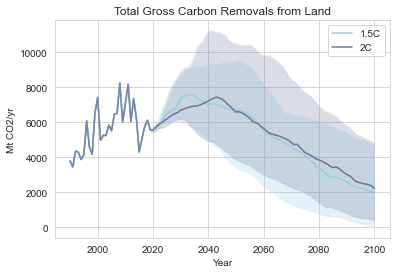

In [32]:
fig, ax = plt.subplots()
data = pyam.concat([make_quantiles(df, 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land', cat) for cat in ['C1', 'C3']])
data = data.rename({'model': categories_to_temp})
(
        data
        .filter(scenario='*0.5*')
        .plot
        .line(color='model', ax=ax, legend=True)
)
(
        data
        .filter(scenario=['*0.25*', '*0.75*'], keep=False)
        .plot
        .line(color='model', fill_between=True, ax=ax, alpha=0.1)
)
ax.set_title('Total Gross Carbon Removals from Land')

In [34]:
# fraction of *new* cdr
# negative values arise because land begins to store less carbon than it did in 2020
# accordingly, this metric only really makes sense until ~2050
new_share = share_of_cdr_data(df, categories_to_temp, offset=2020)
new_share.round(decimals=2)

2030  2040  2050  \
model scenario region variable                unit                         
1.5C  0.25     World  Land Share of Total CDR fraction  0.74  0.30 -0.09   
      0.5      World  Land Share of Total CDR fraction  0.89  0.58  0.27   
      0.75     World  Land Share of Total CDR fraction  0.94  0.73  0.51   
2C    0.25     World  Land Share of Total CDR fraction  0.92  0.49  0.07   
      0.5      World  Land Share of Total CDR fraction  0.98  0.84  0.63   
      0.75     World  Land Share of Total CDR fraction  1.00  0.92  0.79   

                                                        2060  2070  2080  \
model scenario region variable                unit                         
1.5C  0.25     World  Land Share of Total CDR fraction -0.39 -0.53 -0.61   
      0.5      World  Land Share of Total CDR fraction  0.05 -0.19 -0.40   
      0.75     World  Land Share of Total CDR fraction  0.23  0.02 -0.12   
2C    0.25     World  Land Share of Total CDR fraction -0.26 -0.53 -0.60   
      0.5      World  Land Share of Total CDR fraction  0.34  0.03 -0.19   
      0.75     World  Land Share of Total CDR fraction  0.52  0.22  0.01   

                                                        2090  2100  
model scenario region variable                unit                  
1.5C  0.25     World  Land Share of Total CDR fraction -0.74 -0.79  
      0.5      World  Land Share of Total CDR fraction -0.49 -0.53  
      0.75     World  Land Share of Total CDR fraction -0.12 -0.17  
2C    0.25     World  Land Share of Total CDR fraction -0.71 -0.77  
      0.5      World  Land Share of Total CDR fraction -0.36 -0.55  
      0.75     World  Land Share of Total CDR fraction -0.18 -0.26

In [35]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only from 2020',
 'Cumulative AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Cumulat

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


Text(0.5, 1.0, 'Total Indirect Gross Carbon Removals from Land')

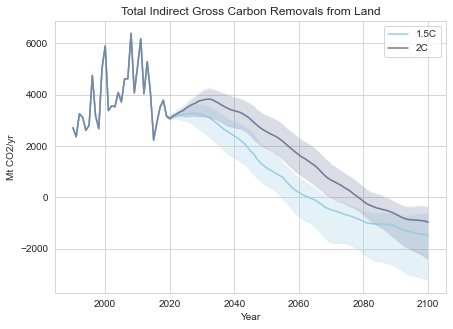

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
data = pyam.concat([make_quantiles(df, 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect', cat) for cat in ['C1', 'C3']])
data = data.rename({'model': categories_to_temp})
(
        data
        .filter(scenario='*0.5*')
        .plot
        .line(color='model', ax=ax, legend=True)
)
(
        data
        .filter(scenario=['*0.25*', '*0.75*'], keep=False)
        .plot
        .line(color='model', fill_between=True, ax=ax, alpha=0.1)
)
ax.set_title('Total Indirect Gross Carbon Removals from Land')

In [37]:
len(
    df
    .filter(variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct', region='World')
    .filter(Category=['C1', 'C2', 'C3'])
#     .filter(Category=['C3'])
    .index
)

407

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


Text(0.5, 1.0, 'Total Direct Gross Carbon Removals from Land')

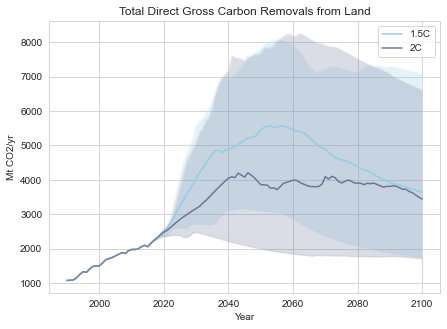

In [38]:
fig, ax = plt.subplots(figsize=(7, 5))
data = pyam.concat([make_quantiles(df, 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct', cat) for cat in ['C1', 'C3']])
data = data.rename({'model': categories_to_temp})
(
        data
        .filter(scenario='*0.5*')
        .plot
        .line(color='model', ax=ax, legend=True)
)
(
        data
        .filter(scenario=['*0.25*', '*0.75*'], keep=False)
        .plot
        .line(color='model', fill_between=True, ax=ax, alpha=0.1)
)
ax.set_title('Total Direct Gross Carbon Removals from Land')